In [1]:
import os
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prediction_utils.pytorch_utils.metrics import StandardEvaluator, CalibrationEvaluator
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from sklearn.calibration import calibration_curve

pd.options.display.max_rows = 100

In [2]:
artifacts_fpath='/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/experiments/dg/artifacts'
baseline_artifacts_fpath='/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/experiments/baseline/artifacts'

In [3]:
algos = {
    'erm':{'title':'ERM','loss':['loss_bce']},
    'irm':{'title':'IRM','loss':['loss_bce','group_regularization','loss']},
    'dro':{'title':'GroupDRO','loss':['loss_bce','loss']},
    'coral':{'title':'CORAL','loss':['loss_bce','group_regularization','loss']}, 
    'adversarial':{'title':'AL','loss':['loss_bce','discriminator']},
}
tasks = {
    'hospital_mortality':'In-Hospital Mortality',
    'LOS_7':'LOS > 7 Days',
    'readmission_30':'Readmission in 30 Days',
    'icu_admission':'Admission to ICU'
}
train_years = {
    '2009_2010_2011_2012':'09-12',
    '2010_2011_2012_2013':'10-13',
    '2011_2012_2013_2014':'11-14',
    '2012_2013_2014_2015':'12-15',
    '2013_2014_2015_2016':'13-16',
    '2014_2015_2016_2017':'14-17',
    '2015_2016_2017_2018':'15-18',
    '2009_2010_2011_2012_2013':'09-13',
    '2009_2010_2011_2012_2013_2014':'09-14',
    '2009_2010_2011_2012_2013_2014_2015':'09-15',
    '2009_2010_2011_2012_2013_2014_2015_2016':'09-16',
    '2009_2010_2011_2012_2013_2014_2015_2016_2017':'09-17',
    '2009_2010_2011_2012_2013_2014_2015_2016_2017_2018':'09-18',
}

Normalized Metrics on 09-12 as a Function of Training Epoch


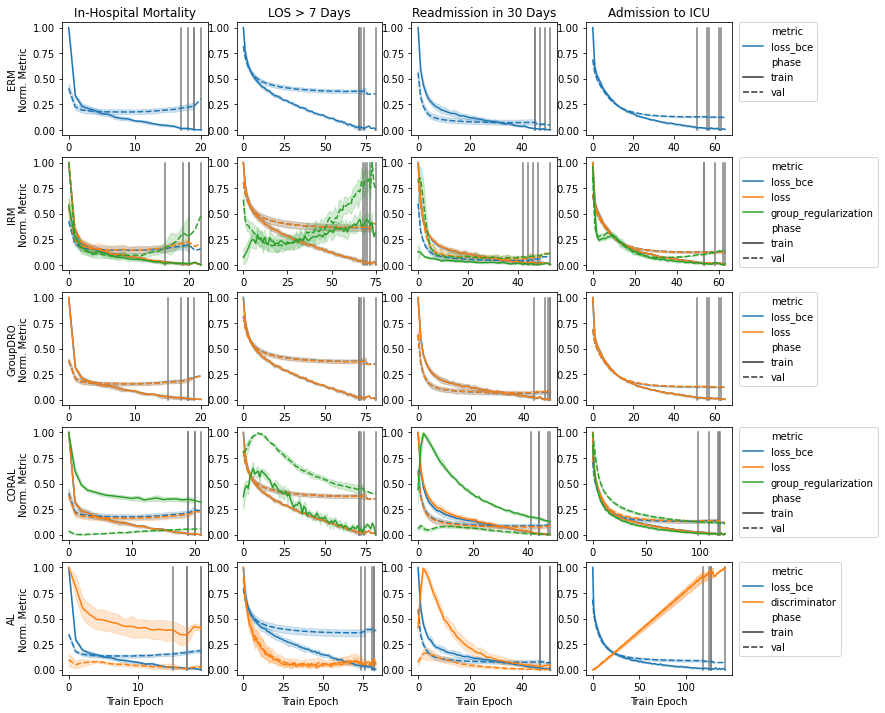

Normalized Metrics on 10-13 as a Function of Training Epoch


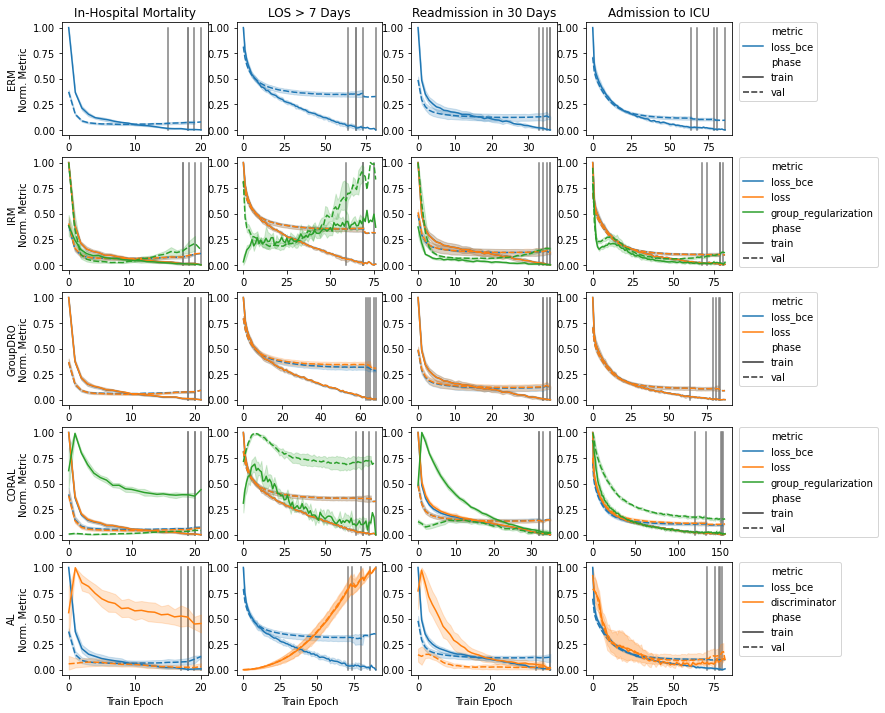

Normalized Metrics on 11-14 as a Function of Training Epoch


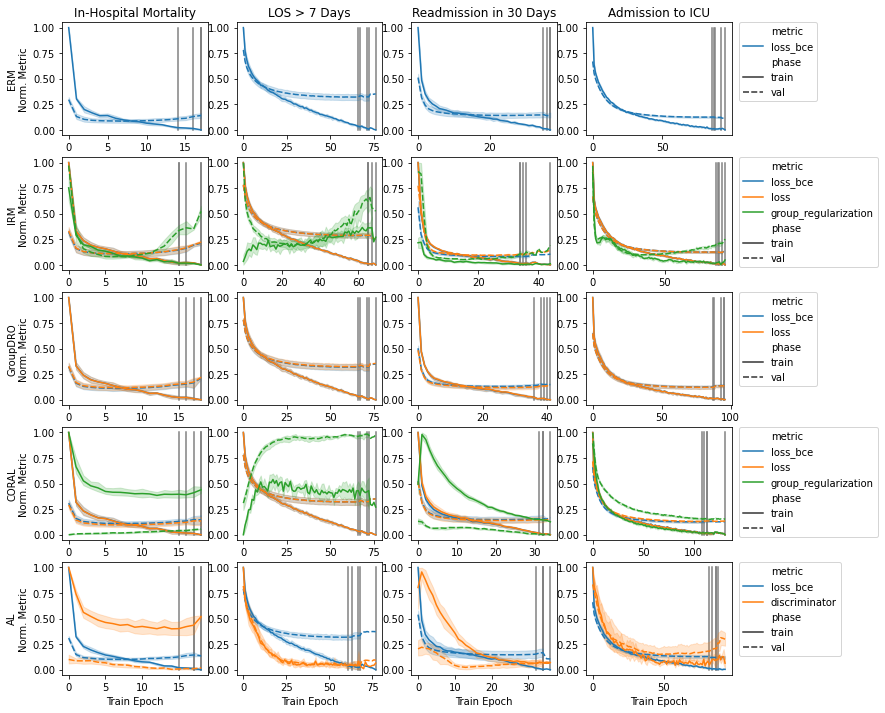

Normalized Metrics on 12-15 as a Function of Training Epoch


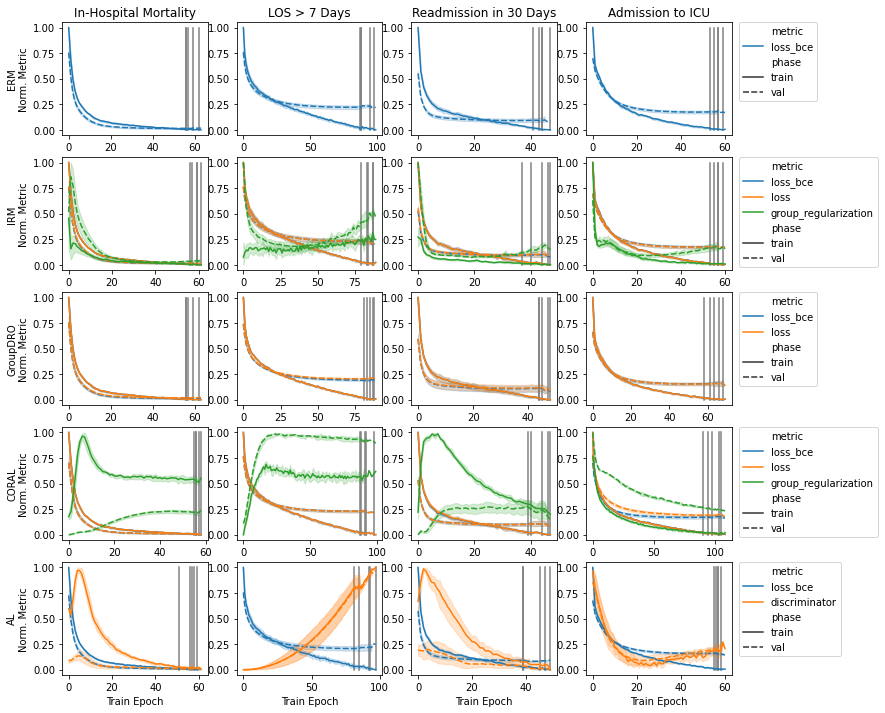

Normalized Metrics on 13-16 as a Function of Training Epoch


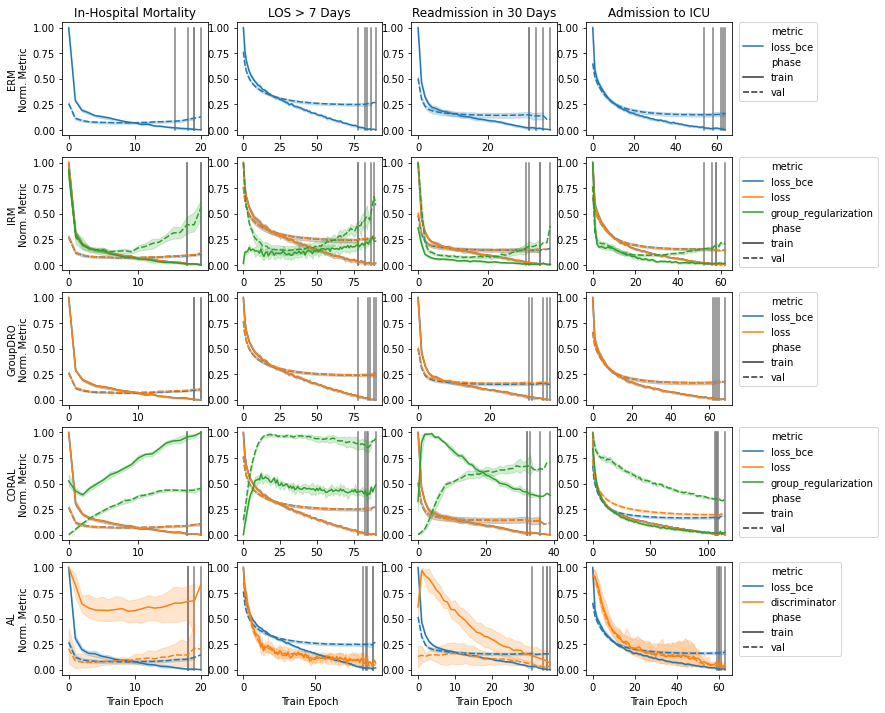

Normalized Metrics on 14-17 as a Function of Training Epoch


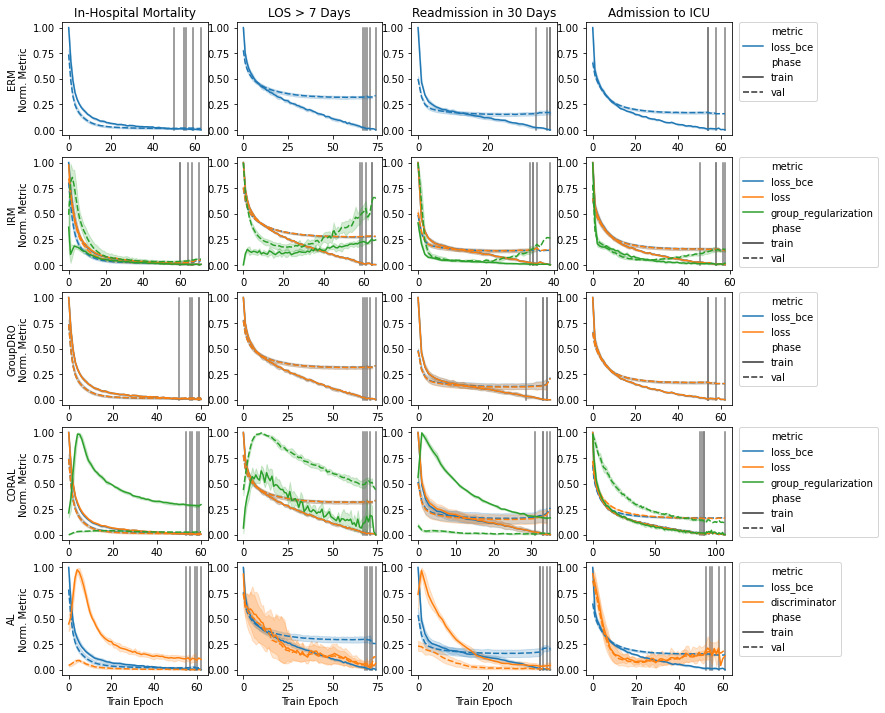

Normalized Metrics on 15-18 as a Function of Training Epoch


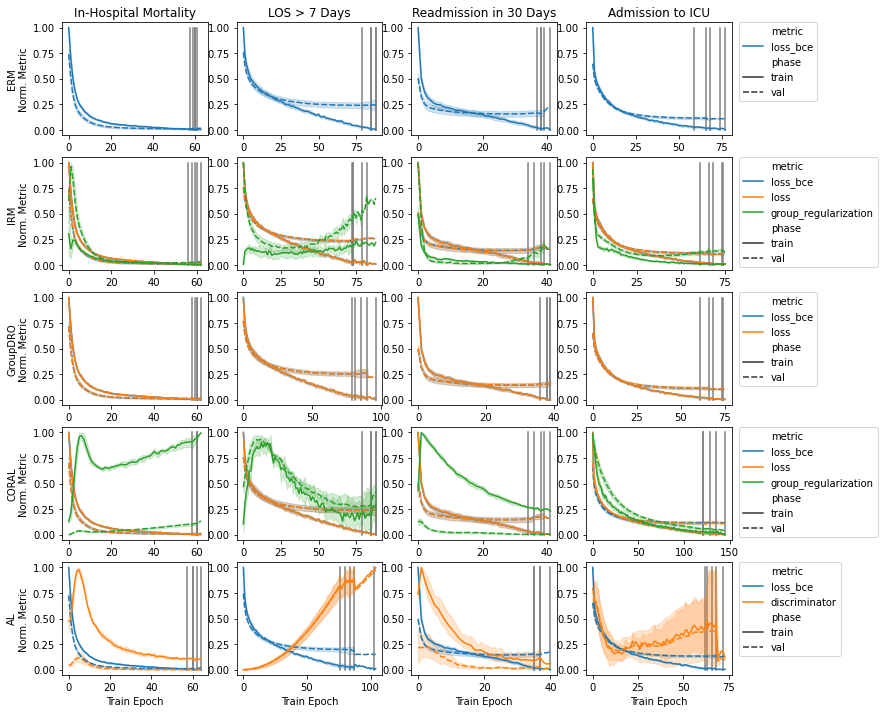

Normalized Metrics on 09-13 as a Function of Training Epoch


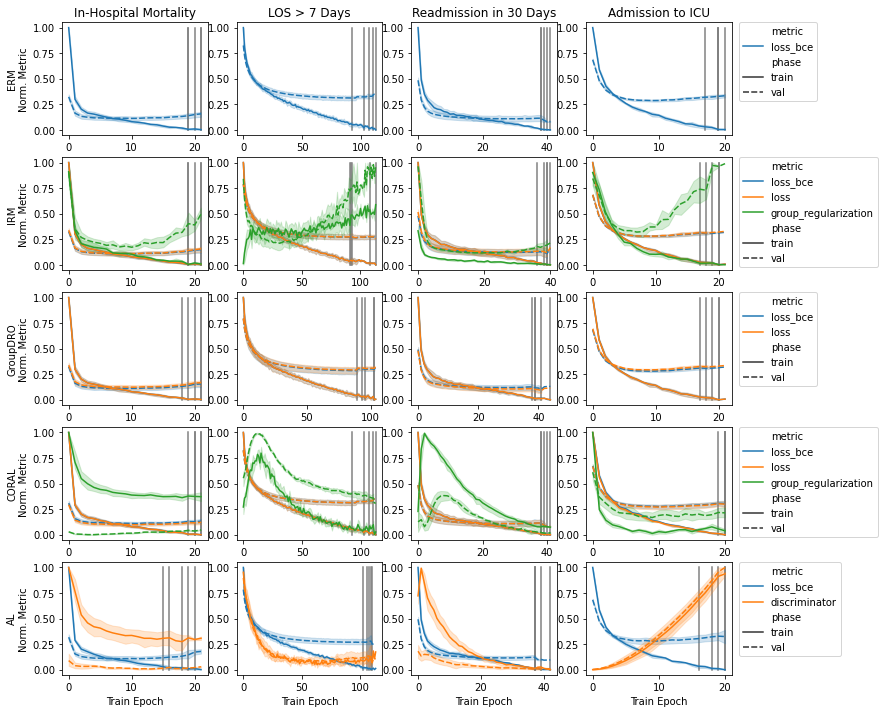

Normalized Metrics on 09-14 as a Function of Training Epoch


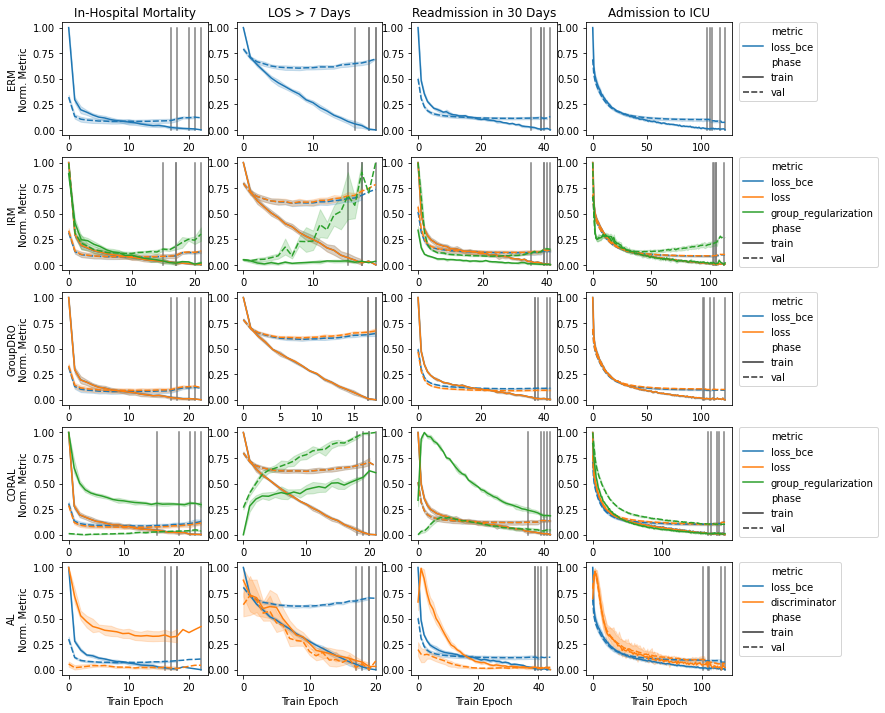

Normalized Metrics on 09-15 as a Function of Training Epoch


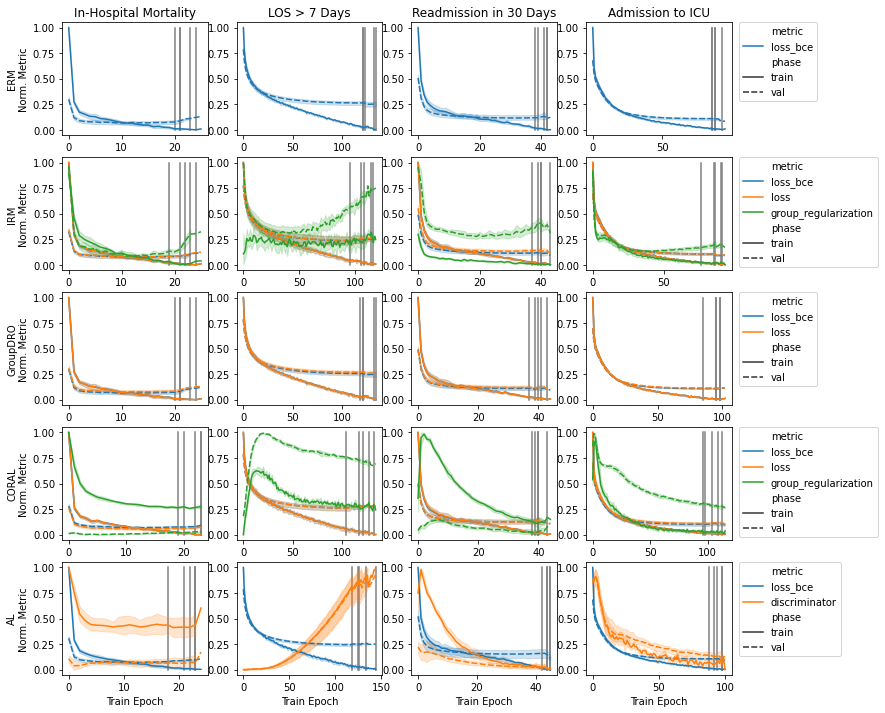

Normalized Metrics on 09-16 as a Function of Training Epoch


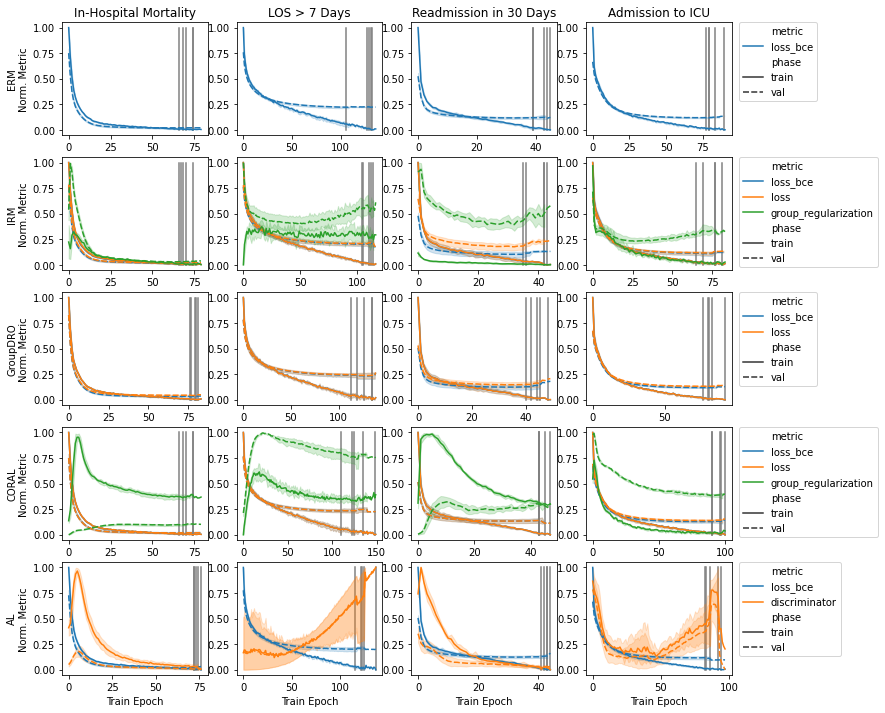

Normalized Metrics on 09-17 as a Function of Training Epoch


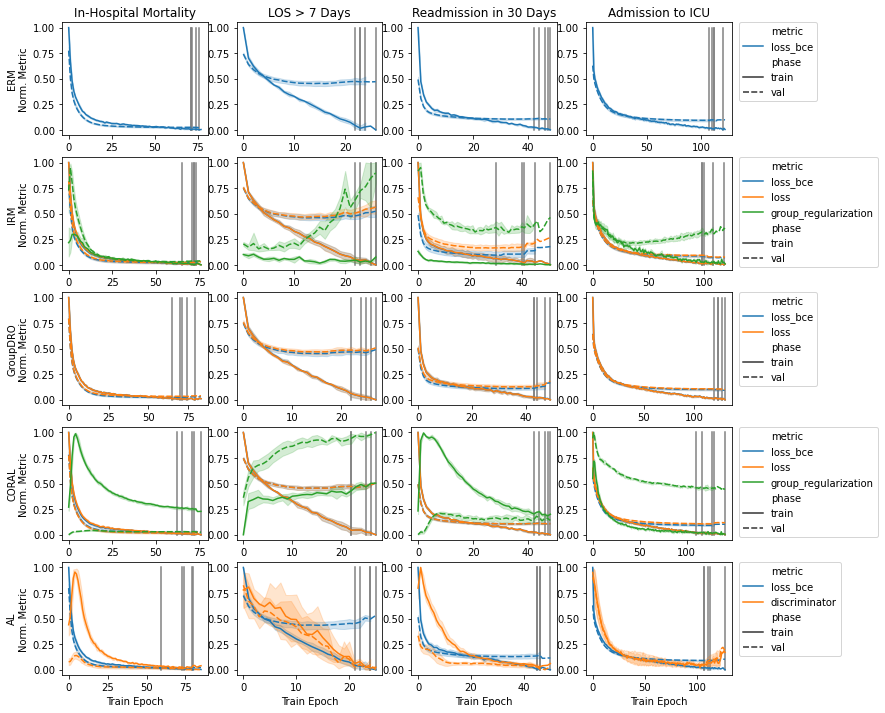

Normalized Metrics on 09-18 as a Function of Training Epoch


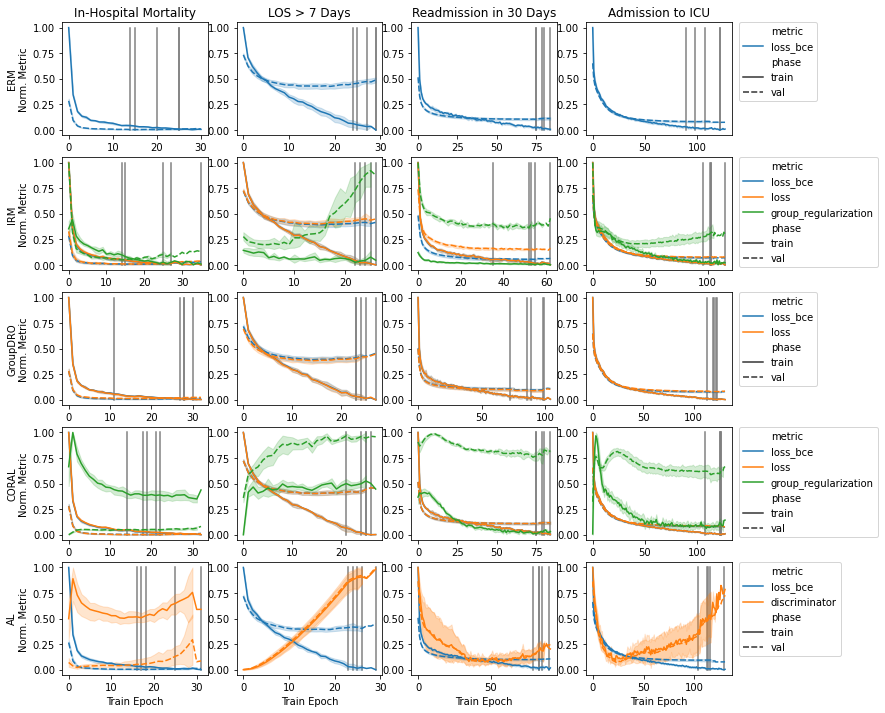

In [4]:
for train_year in train_years:
    
    print(f"Normalized Metrics on {train_years[train_year]} as a Function of Training Epoch")
    
    fig,axes = plt.subplots(len(algos),len(tasks),figsize=(12,12))

    for c,task in enumerate(tasks):
        for r,algo in enumerate(algos):
            df = pd.DataFrame()

            # get selected model
            if algo=='erm':
                fpath = os.path.join(
                    baseline_artifacts_fpath,
                    task,
                    f'models/nn_{train_year}',
                )
            else:
                fpath = os.path.join(
                    artifacts_fpath,
                    task,
                    f'models/{algo}_{train_year}',
                )

            folder_name = [
                x for x in os.listdir(fpath)
                if 'best_model' in x
            ]

            file_names = [
                x for x in os.listdir(f"{fpath}/{folder_name[0]}")
                if "train_scores.csv" in x
            ]

            # load dfs
            df = pd.concat((
                pd.read_csv(
                    f"{fpath}/{folder_name[0]}/{x}"
                ).assign(iter=c)
                for c,x in enumerate(file_names)
            ))
            
            # best epochs
            if algo=='adversarial':
                obj='supervised'
            else:
                obj='loss'
            
            temp_df = df.query("metric==@obj").reset_index(drop=True)
            early_stop_epochs = temp_df.loc[
                temp_df.groupby('iter')['performance'].idxmin(),'epoch'
            ].values
            
            # select loss
            sel_loss = algos[algo]['loss']
            df = df.query("metric==@sel_loss").reset_index(drop=True)

            # normalize metric by train iteration
            df['performance']=df.groupby(['metric','iter'])['performance'].transform(
                lambda x: (x - x.min()) / (x.max()-x.min())
            )
            
            # main plot
            sns.lineplot(
                data=df,
                x='epoch',
                y='performance',
                hue='metric',
                style='phase',
                ax = axes[r][c],
                legend=False if c < len(tasks)-1 else "brief"
            )
            
            # plot early stopping epochs
            for x in early_stop_epochs:
                axes[r][c].plot(
                    [x,x],
                    [0,1],
                    c='grey',
                    zorder=0
                )
            
            if c==len(tasks)-1:
                axes[r][c].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            if r==0:
                axes[r][c].set_title(tasks[task])

            if r==len(algos)-1:
                axes[r][c].set_xlabel('Train Epoch')
            else:
                axes[r][c].set_xlabel('')

            if c==0:
                axes[r][c].set_ylabel(f"{algos[algo]['title']}\nNorm. Metric")
            else:
                axes[r][c].set_ylabel('')

    plt.show()